In [3]:
!pip install torch diffusers transformers compel

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 191.5/191.5 kB 3.8 MB/s eta 0:00:007.1 MB/s eta 0:00:01


In [1]:
%load_ext autoreload
%autoreload 2

In [2]:
import torch
from compel import Compel, SplitLongTextMode
from diffusers import StableDiffusionPipeline, DPMSolverMultistepScheduler
from torch import Generator

device = "mps"
pipeline: StableDiffusionPipeline = StableDiffusionPipeline.from_pretrained("runwayml/stable-diffusion-v1-5").to(device)
# dpm++2m
pipeline.scheduler = DPMSolverMultistepScheduler.from_config(pipeline.scheduler.config,
                                                             algorithm_type="dpmsolver++")

compel = Compel(tokenizer=pipeline.tokenizer, text_encoder=pipeline.text_encoder, truncate_long_prompts=False)


/Users/damian/2.current/compel/.venv/lib/python3.12/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm
Loading pipeline components...: 100%|██████████| 7/7 [00:00<00:00, 25.63it/s]


In [3]:
compel.build_conditioning_tensor("a test", return_tokenization=True)

todo: copy CLS token from chunk 0 to all other chunks


(tensor([[[-0.3884,  0.0229, -0.0522,  ..., -0.4899, -0.3066,  0.0675],
          [ 0.0290, -1.3258,  0.3085,  ..., -0.5257,  0.9768,  0.6652],
          [-1.0184, -0.4076, -0.3607,  ..., -0.4416,  0.7352,  1.0469],
          ...,
          [-0.2526, -0.6158, -1.1063,  ...,  0.1271, -0.3537, -0.9431],
          [-0.2455, -0.6272, -1.1032,  ...,  0.1589, -0.3656, -0.9374],
          [-0.3024, -0.5248, -1.0520,  ...,  0.1083, -0.2831, -0.9586]]],
        device='mps:0', grad_fn=<CatBackward0>),
 [tensor([[49406,   320,  1628, 49407, 49407, 49407, 49407, 49407, 49407, 49407,
           49407, 49407, 49407, 49407, 49407, 49407, 49407, 49407, 49407, 49407,
           49407, 49407, 49407, 49407, 49407, 49407, 49407, 49407, 49407, 49407,
           49407, 49407, 49407, 49407, 49407, 49407, 49407, 49407, 49407, 49407,
           49407, 49407, 49407, 49407, 49407, 49407, 49407, 49407, 49407, 49407,
           49407, 49407, 49407, 49407, 49407, 49407, 49407, 49407, 49407, 49407,
           49407

split_long_text_mode is SplitLongTextMode.MERGE_CLS_TOKENS -> merging CLS embeddings from all 2 chunks
split_long_text_mode is SplitLongTextMode.MERGE_CLS_TOKENS -> merging CLS embeddings from all 1 chunks
split_long_text_mode is SplitLongTextMode.MERGE_CLS_TOKENS -> merging CLS embeddings from all 1 chunks


100%|██████████| 30/30 [00:37<00:00,  1.26s/it]


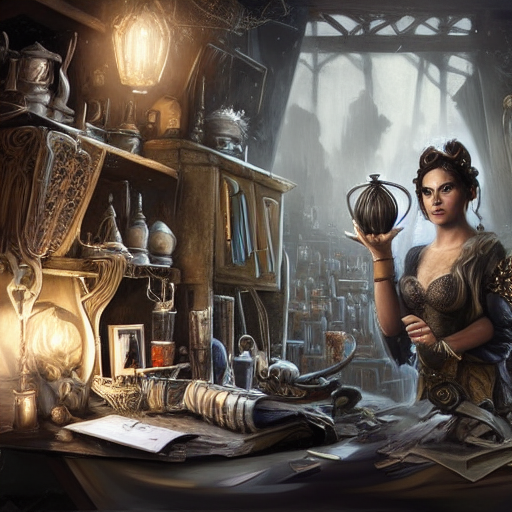

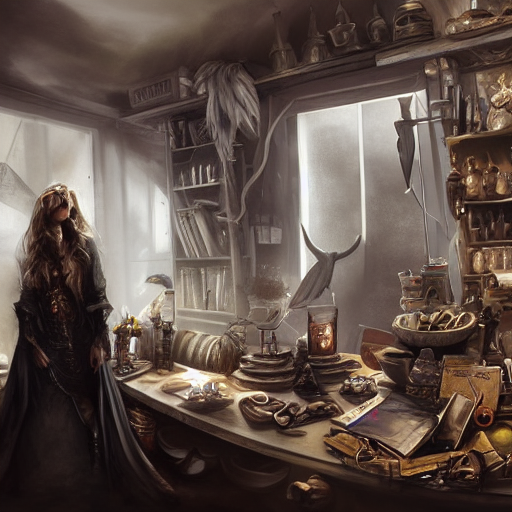

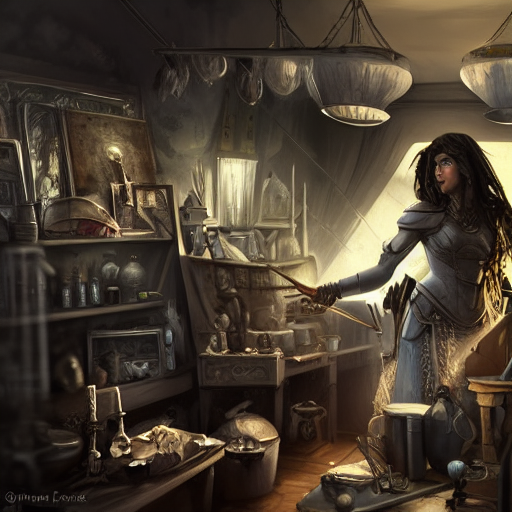

split_long_text_mode is SplitLongTextMode.COPY_FIRST_CLS_TOKEN -> copying CLS embedding from prompt chunk 0 to subsequent 1 chunks


100%|██████████| 30/30 [00:39<00:00,  1.30s/it]


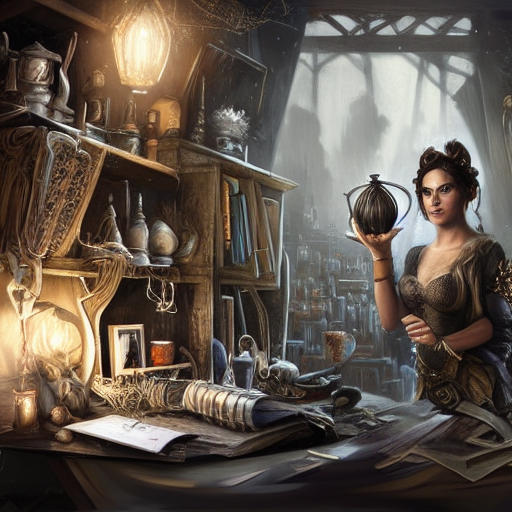

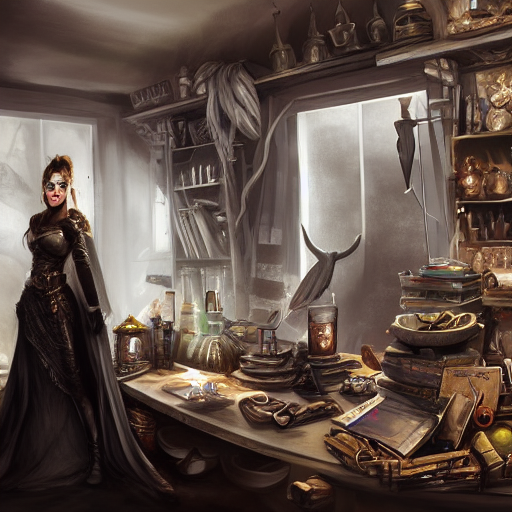

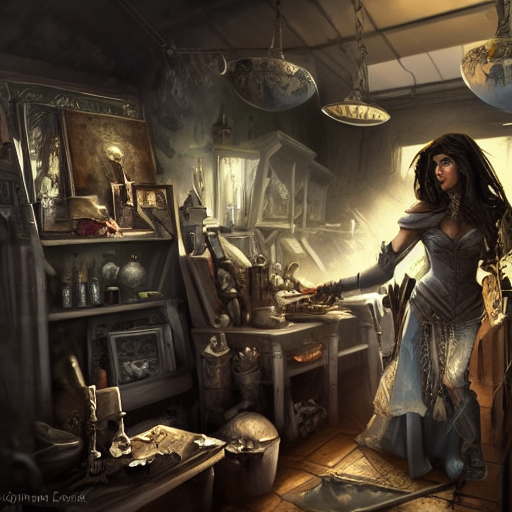

100%|██████████| 30/30 [00:38<00:00,  1.28s/it]


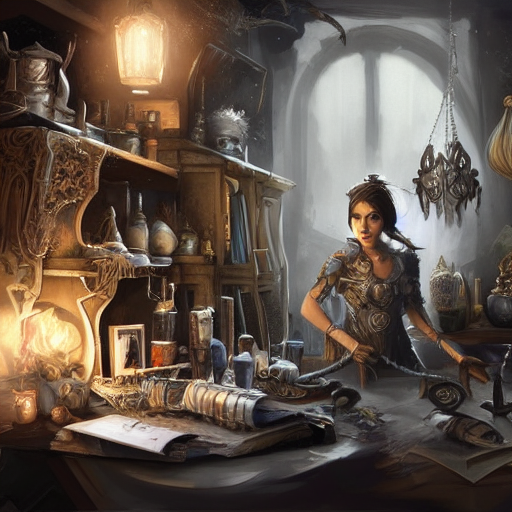

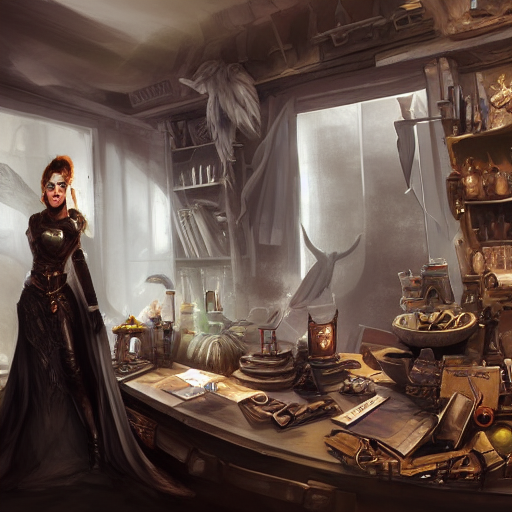

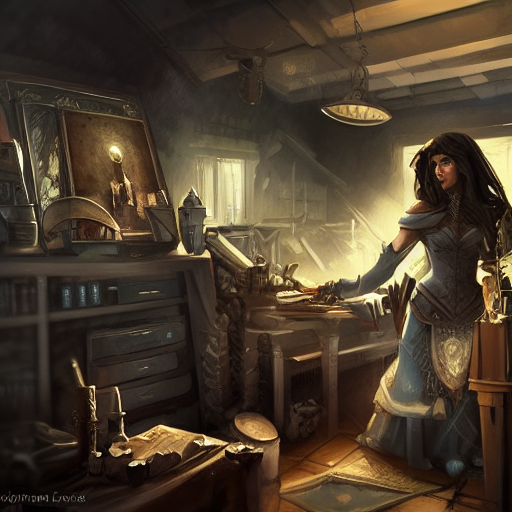

In [3]:
from compel import CompelForSD, SplitLongTextMode

#prompt = "a cat playing with a ball in the forest"
prompt = "photo, awesome, enchantress in her cluttered workshop , grey background, headshot, head++. tabletop roleplaying artwork. Dynamic, high-fantasy digital painting with dramatic lighting, painterly textures, and intricate detail. , intense action, and blends realism with impressionistic brushstrokes for an immersive composition. , concept art, clean outlines, painterly, highlights, shadows"

seed = 123

compel = CompelForSD(pipeline)

compel.compel.conditioning_provider.split_long_text_mode = SplitLongTextMode.SENTENCES | SplitLongTextMode.MERGE_CLS_TOKENS
conditioning = compel(prompt, negative_prompt="ugly, deformed, misshapen, blurry")
fixed_seed_generator = Generator(device="cpu").manual_seed(seed)
images = pipeline(prompt_embeds=conditioning.embeds,
                 negative_prompt_embeds=conditioning.negative_embeds,
                 num_inference_steps=30,
                 num_images_per_prompt=3,
                 generator=fixed_seed_generator).images
for i, image in enumerate(images):
    display(image)
    image.save(f'sd1-mergecls-{i}.jpg', quality=95)

compel.compel.conditioning_provider.split_long_text_mode = SplitLongTextMode.SENTENCES | SplitLongTextMode.COPY_FIRST_CLS_TOKEN
conditioning = compel(prompt, negative_prompt="ugly, deformed, misshapen, blurry")
fixed_seed_generator = Generator(device="cpu").manual_seed(seed)
images = pipeline(prompt_embeds=conditioning.embeds,
                 negative_prompt_embeds=conditioning.negative_embeds,
                 num_inference_steps=30,
                 num_images_per_prompt=3,
                 generator=fixed_seed_generator).images
for i, image in enumerate(images):
    display(image)
    image.save(f'sd1-copycls0-{i}.jpg', quality=95)

compel.compel.conditioning_provider.split_long_text_mode = SplitLongTextMode.SENTENCES
conditioning = compel(prompt, negative_prompt="ugly, deformed, misshapen, blurry")
fixed_seed_generator = Generator(device="cpu").manual_seed(seed)
images = pipeline(prompt_embeds=conditioning.embeds,
                 negative_prompt_embeds=conditioning.negative_embeds,
                 num_inference_steps=30,
                 num_images_per_prompt=3,
                 generator=fixed_seed_generator).images
for i, image in enumerate(images):
    display(image)
    image.save(f'sd1-nocopycls0-b-{i}.jpg', quality=95)



In [ ]:
compel = CompelForSD(pipeline)
conditioning = compel(prompt, negative_prompt="ugly")
fixed_seed_generator = Generator(device="cpu").manual_seed(seed)
image = pipeline(prompt_embeds=conditioning.embeds,
                 negative_prompt_embeds=conditioning.negative_embeds,
                 num_inference_steps=30,
                 generator=fixed_seed_generator).images[0]
display(image)

  0%|          | 0/7 [00:00<?, ?it/s]

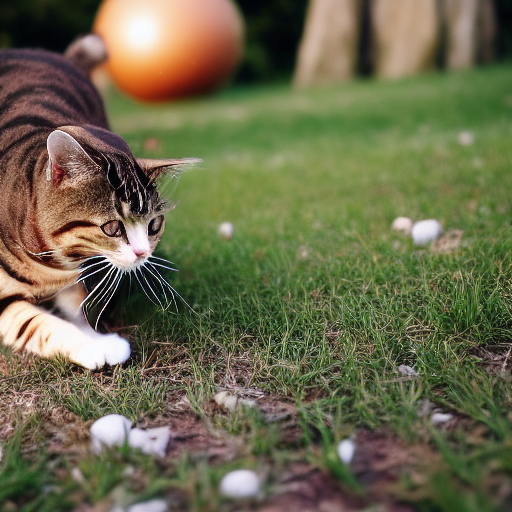

In [4]:
prompt = "a cat playing with a ball (in the forest)-----"
seed = 123

embeds = compel.build_conditioning_tensor(prompt)
fixed_seed_generator = Generator(device="cpu" if compel.device.type == "mps" else compel.device).manual_seed(seed)
image = pipeline(prompt_embeds=embeds, 
                 num_inference_steps=7, 
                 generator=fixed_seed_generator).images[0]
display(image)

  0%|          | 0/7 [00:00<?, ?it/s]

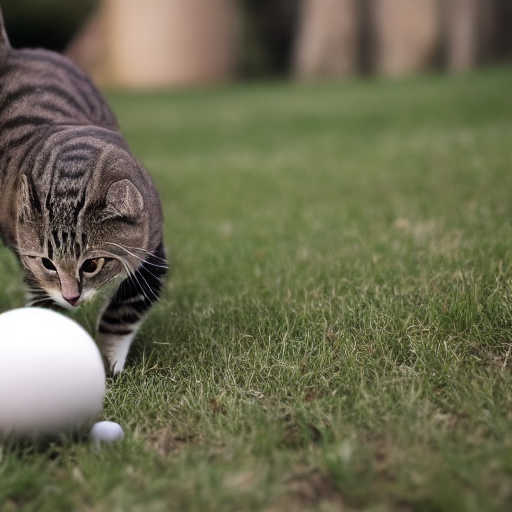

In [6]:
prompt = "a cat playing with a ball++ (in the forest)-----"
seed = 123

embeds = compel.build_conditioning_tensor(prompt)
fixed_seed_generator = Generator(device="cpu" if compel.device.type == "mps" else compel.device).manual_seed(seed)
image = pipeline(prompt_embeds=embeds, 
                 num_inference_steps=7, 
                 generator=fixed_seed_generator).images[0]
display(image)